In [128]:
import numpy as np
import fitsio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as lines
from glob import glob
from time import time
import sys
import matplotlib.colors as colors
from scipy.ndimage.filters import gaussian_filter1d


# sys.path.append('/global/homes/j/jmccull/sompz/')
# from sompz import SelfOrganizingMap
# from sompz import *
# from sompz.som import *

sys.path.append('/pscratch/sd/j/jmccull/spec_surveys/4C3R2/DESI/')
from myutils.som import *
from myutils.io import *
from myutils.plot import *

plt.rcParams["font.family"] = "serif"

#kernel desi-ia

/tmp/ipykernel_2289772/2373076775.py:11: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


# Read in a fiber assign catalog and characterize

In [2]:
deep_dir = '/pscratch/sd/j/jmccull/desi_deep/'
cat = fitsio.read(deep_dir + 'tertiary-targets-9999-assignv4.fits',ext=1)
print(cat.shape)
print(cat.dtype.names)
print([(col, cat[col].shape) for col in cat.dtype.names])
cols_to_keep = ['RA','DEC','I_MAG','NASSIGN','NGOAL','EXP_TIME','SUBPRIORITY','SUCCESS_PROB']
cat = cat[cols_to_keep]

(24511,)
('RA', 'DEC', 'PMRA', 'PMDEC', 'REF_EPOCH', 'OVERRIDE', 'I_MAG', 'TERTIARY_TARGET', 'AVAIL', 'NAVAIL', 'TARGETID', 'SUBPRIORITY', 'CHECKER', 'NGOAL', 'FIBERS', 'ASSIGN', 'NASSIGN', 'EXP_TIME', 'SUCCESS_PROB')
[('RA', (24511,)), ('DEC', (24511,)), ('PMRA', (24511,)), ('PMDEC', (24511,)), ('REF_EPOCH', (24511,)), ('OVERRIDE', (24511,)), ('I_MAG', (24511,)), ('TERTIARY_TARGET', (24511,)), ('AVAIL', (24511, 95)), ('NAVAIL', (24511,)), ('TARGETID', (24511,)), ('SUBPRIORITY', (24511,)), ('CHECKER', (24511,)), ('NGOAL', (24511,)), ('FIBERS', (24511, 95)), ('ASSIGN', (24511, 95)), ('NASSIGN', (24511,)), ('EXP_TIME', (24511,)), ('SUCCESS_PROB', (24511,))]


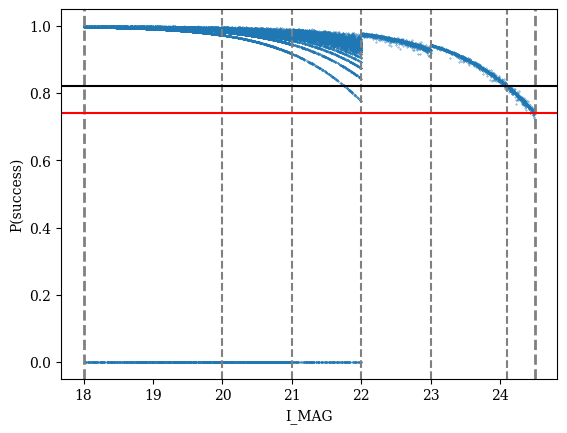

In [3]:
plt.plot(cat['I_MAG'], cat['SUCCESS_PROB'],'o',markersize=0.3,alpha=1.0)
plt.xlabel('I_MAG')
plt.ylabel('P(success)')
plt.axvline(x=24.5,linestyle='dashed',color='gray',linewidth=2)
plt.axvline(x=23.0,linestyle='dashed',color='gray')
plt.axvline(x=22.0,linestyle='dashed',color='gray')
plt.axvline(x=21.0,linestyle='dashed',color='gray')
plt.axvline(x=20.0,linestyle='dashed',color='gray')
plt.axvline(x=24.1,linestyle='dashed',color='gray')

plt.axvline(x=18.0,linestyle='dashed',color='gray',linewidth=2)
plt.axhline(y=0.74,color='red')
plt.axhline(y=0.82,color='black')

plt.show()

In [4]:
mask = cat['NGOAL'] <= cat['NASSIGN'] #recalc to use sum of success probabilities per mag
print('{0} of {1} targets are getting the number of fibers we ask out'.format(np.sum(mask),len(mask)))

19318 of 24511 targets are getting the number of fibers we ask out


In [5]:
# read in the full targeting post selection flag, pre-downsampling
cosmos_deep_fname = '/pscratch/sd/j/jmccull/desi_deep/target_selection/TEST3_COSMOS_LSSTY1_target_list_unresampled.fits'
cat_full = fitsio.read(cosmos_deep_fname,ext=1)
print(cat_full.shape)
print(cat_full.dtype.names)

(748540,)
('RA', 'DEC', 'PMRA', 'PMDEC', 'REF_EPOCH', 'OVERRIDE', 'I_MAG')


In [6]:
cosmos_desiy1 = '/global/cfs/cdirs/desi/users/jratajcz/C3PZ/COSMOS/v11182024/COSMOS_specz_catalog.fits'
cosmos_desiy1 = fitsio.read(cosmos_desiy1,ext=1)
print(cosmos_desiy1.shape)
print(cosmos_desiy1.dtype.names)

(233315,)
('TARGETID', 'TARGET_RA', 'TARGET_DEC', 'DESINAME', 'OBJTYPE', 'PMRA', 'PMDEC', 'SURVEY', 'PROGRAM', 'Z', 'ZERR', 'ZWARN', 'CHI2', 'FITMETHOD', 'NPIXELS', 'SPECTYPE', 'SUBTYPE', 'DELTACHI2', 'best_Z', 'dz', 'CATALOG_CUT', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'SCND_TARGET', 'SV1_DESI_TARGET', 'SV1_BGS_TARGET', 'SV1_MWS_TARGET', 'SV1_SCND_TARGET', 'SV3_DESI_TARGET', 'SV3_BGS_TARGET', 'SV3_MWS_TARGET', 'SV3_SCND_TARGET', 'TERTIARY_TARGET', 'HAS_RVS', 'VRAD', 'VRAD_ERR', 'VRAD_SKEW', 'VRAD_KURT', 'LOGG', 'TEFF', 'ALPHAFE', 'FEH', 'LOGG_ERR', 'TEFF_ERR', 'ALPHAFE_ERR', 'FEH_ERR', 'VSINI', 'RVS_WARN', 'LRG_MASK', 'ELG_MASK', 'HAS_DECALS_DR9', 'HAS_DECAM_DEEP', 'HAS_HSC_UD_PDR3', 'HAS_HSC_WIDE_PDR3', 'HAS_MERIAN')


In [7]:
#also read in COSMOS photometry in the field with 9-band photometry the matched catalog Dan passed Daniel:
cosmos = fitsio.read("/pscratch/sd/j/jmccull/spec_surveys/4C3R2/SOM/cosmos_matched_som_for_danielg.fits",ext=1)
print(cosmos.shape)
print(cosmos.dtype.names)
print([(col, cosmos[col].shape) for col in cosmos.dtype.names])

(323192,)
('ID', 'XP', 'YP', 'RA', 'DEC', 'R2', 'R2_LAIGLE', 'I_FLAG', 'K_FLAG', 'SOURCE', 'UTOT', 'GTOT', 'RTOT', 'ITOT_1', 'ZTOT', 'YTOT', 'JTOT', 'HTOT', 'KSTOT', 'UTERR', 'GTERR', 'RTERR', 'ITERR', 'ZTERR', 'YTERR', 'JTERR', 'HTERR', 'KSTERR', 'U', 'G', 'R', 'I', 'Z', 'Y', 'J', 'H', 'KS', 'UERR', 'GERR', 'RERR', 'IERR', 'ZERR', 'YERR', 'JERR', 'HERR', 'KSERR', 'E_B_V_', 'RIZ', 'RIZERR', 'INSTR', 'PHOTZ', 'CELLINDEX', 'CELLX', 'CELLY', 'SEP', 'HOUR', 'MINUTE', 'SECOND', 'DEGREE', 'AMIN', 'ASEC')
[('ID', (323192,)), ('XP', (323192,)), ('YP', (323192,)), ('RA', (323192,)), ('DEC', (323192,)), ('R2', (323192,)), ('R2_LAIGLE', (323192,)), ('I_FLAG', (323192,)), ('K_FLAG', (323192,)), ('SOURCE', (323192,)), ('UTOT', (323192,)), ('GTOT', (323192,)), ('RTOT', (323192,)), ('ITOT_1', (323192,)), ('ZTOT', (323192,)), ('YTOT', (323192,)), ('JTOT', (323192,)), ('HTOT', (323192,)), ('KSTOT', (323192,)), ('UTERR', (323192,)), ('GTERR', (323192,)), ('RTERR', (323192,)), ('ITERR', (323192,)), ('ZTE

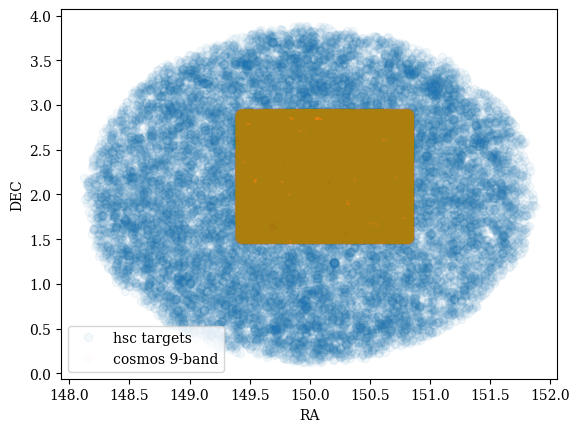

In [8]:
#compare footprints
plt.plot(cat['RA'],cat['DEC'],'o',alpha=0.05,label='hsc targets')
plt.plot(cosmos['RA'],cosmos['DEC'],'o',alpha=0.01,label='cosmos 9-band')

plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend(loc='lower left')
plt.show()

In [9]:
#match them together
start = time()
matched_targets = match_small2large(cosmos,cat_full,smallcols=['RA','DEC'],largecols=['RA','DEC'],acc_err=1.0/3600.,
                                         dfstat=[False,False])
print('time elapsed: {}'.format(time()-start))

start = time()
matched_obs = match_small2large(cat.byteswap().newbyteorder(),cosmos,smallcols=['RA','DEC'],largecols=['RA','DEC'],acc_err=1.0/3600.,
                                         dfstat=[False,False])
print('time elapsed: {}'.format(time()-start))

#also match the cosmos xmm catalog
start = time()
matched_desiy1 = match_small2large(cosmos_desiy1.byteswap().newbyteorder(),cosmos,smallcols=['TARGET_RA','TARGET_DEC'],largecols=['RA','DEC'],acc_err=1.0/3600.,
                                         dfstat=[False,False])
print('time elapsed: {}'.format(time()-start))

start = time()
matched_desiy1_hsc = match_small2large(cosmos_desiy1,cat_full,smallcols=['TARGET_RA','TARGET_DEC'],largecols=['RA','DEC'],acc_err=1.0/3600.,
                                         dfstat=[False,False])
print('time elapsed: {}'.format(time()-start))

matching now, making KDTree....
(748540, 2)
made KDTree, now trying to take dataframe of size:
(323192,)
to dataframe of size:
(748540,)
using an acceptable error of 1.0"
We have 87522 matches out of 323192 objects
Total fraction kept after matching: 0.2708049704200599
combining two arrays...
finished!
time elapsed: 0.8431334495544434
matching now, making KDTree....
(323192, 2)
made KDTree, now trying to take dataframe of size:
(24511,)
to dataframe of size:
(323192,)
using an acceptable error of 1.0"
We have 4598 matches out of 24511 objects
Total fraction kept after matching: 0.18758924564481252
combining two arrays...
finished!
time elapsed: 0.19353127479553223
matching now, making KDTree....
(323192, 2)
made KDTree, now trying to take dataframe of size:
(233315,)
to dataframe of size:
(323192,)
using an acceptable error of 1.0"
We have 43053 matches out of 233315 objects
Total fraction kept after matching: 0.18452735572080664
combining two arrays...
finished!
time elapsed: 0.797995

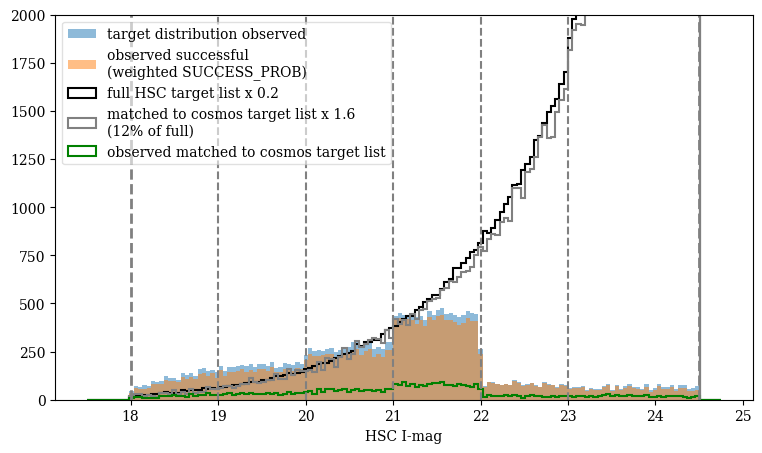

In [10]:
plt.figure(figsize=(9,5))
bins = np.linspace(17.5,24.75,num=150)
plt.hist(cat['I_MAG'],bins=bins,alpha=0.5, label='target distribution observed')
plt.hist(cat['I_MAG'],bins=bins,alpha=0.5,label='observed successful\n(weighted SUCCESS_PROB)',weights=cat['SUCCESS_PROB'])
plt.hist(cat_full['I_MAG'], bins=bins, color='black',histtype='step',linewidth=1.5,alpha=1.0,label='full HSC target list x 0.2',
         density=False, weights=0.2*np.ones(len(cat_full['I_MAG'])))

plt.hist(matched_targets['I_MAG'], bins=bins, color='gray',histtype='step',linewidth=1.5,alpha=1.0,label='matched to cosmos target list x 1.6\n(12% of full)',
         density=False, weights=1.6*np.ones(len(matched_targets['I_MAG'])))

plt.hist(matched_obs['I_MAG'], bins=bins, color='green',histtype='step',linewidth=1.5,alpha=1.0,label='observed matched to cosmos target list',#\n(weighted SUCCESS_PROB)',
         density=False, weights=np.ones(len(matched_obs['SUCCESS_PROB'])))
plt.xlabel('HSC I-mag')
plt.axvline(x=24.5,linestyle='dashed',color='gray',linewidth=2)
plt.axvline(x=23.0,linestyle='dashed',color='gray')
plt.axvline(x=22.0,linestyle='dashed',color='gray')
plt.axvline(x=21.0,linestyle='dashed',color='gray')
plt.axvline(x=20.0,linestyle='dashed',color='gray')
plt.axvline(x=19.0,linestyle='dashed',color='gray')
plt.axvline(x=18.0,linestyle='dashed',color='gray',linewidth=2)
plt.legend(loc='upper left',frameon=True, framealpha=0.6)
plt.ylim([0,2000])
plt.show()

# Mock up SOM coverage based on i-band selections
We have a limited overlap area with existing 9-band photometry, but with extended photometry (as we'll eventually have with LSST/Euclid), we can mock up relevance for Stage III and Stage IV separately (restricting to COSMOS, or allowing larger COSMOS footprint + XMM)

In [63]:
#and modify biprateep's uniform sample function it to do what we want
def match_resample(data, tomatch, data_min, data_max, bin_size = 0.05, seed=42, rejection_scale = None,
                   datacol='I',tomatchcol='I_MAG',tomatch_weight='SUCCESS_PROB',invert=False, verbose=False):
    #we take an existing catalog 'data' and match it's i-band selection to what is in another catalog 'tomatch' 
    # - recreating the magnitude selection where we have 9-band colors
    data_sel = data[datacol].copy()

    bins = int((data_max-data_min)/bin_size)
    bin_edges = np.linspace(data_min,data_max,bins)
    
    counts_data, _ = np.histogram(data_sel, bins=bin_edges,density=False)
    
    if tomatch_weight is None: #if we actually don't care about matching the weighted distribution of this catalog
        tomatch_weights = np.ones(len(tomatch[tomatchcol]))
    else:
        tomatch_weights = tomatch[tomatch_weight] #if we do want to match the weighted distribution of this catalog
        
    counts_tomatch, _ = np.histogram(tomatch[tomatchcol], bins=bin_edges,weights=tomatch_weights,density=False)

    bin_membership = np.digitize(data_sel, bin_edges,right=True)
    #bin_membership_tomatch = np.digitize(tomatch[tomatchcol], bin_edges,right=True) #uneccessary to get bin membership


    weights = counts_data[bin_membership-1]/counts_tomatch[bin_membership -1]
    weights = 1/weights
    #weights /= weights.sum()

    # perform rejection sampling
    if rejection_scale is None:
        #rejection_scale = weights.max()
        rejection_scale = 1.
        
    rng = np.random.default_rng(seed=seed)
    sampling_mask = rng.uniform(size=len(weights)) < weights/rejection_scale
    if verbose:
        print('pre-adjusting for undersampled we take {0} of {1} galaxies.'.format(sampling_mask.sum(),len(sampling_mask)))
        #check where this is the case:
        print(counts_data.shape)
        print(counts_tomatch.shape)
        plt.plot(counts_data,counts_tomatch,'o')
        plt.xlabel('counts data')
        plt.ylabel('counts to match to')
        plt.plot(counts_data,counts_data,'--',color='gray')
        plt.show()
    mask = (counts_data[bin_membership-1] < counts_tomatch[bin_membership -1]) #where we have too few objects, take them all
    sampling_mask[mask] = np.ones(mask.sum()).astype(bool)
    if verbose:
        print('post-adjusting for undersampled we take {0} of {1} galaxies.'.format(sampling_mask.sum(),len(sampling_mask)))

    return sampling_mask, weights

mag_bin_mins = [18,19,20,21,22,23]
mag_bin_maxs = [19,20,21,22,23,24.5]
rejection_scales=[1,1,1,1,1,1]
cosmoslike_cat = []
sizes = []
weights = []
for mins,maxs,scales in zip(mag_bin_mins,mag_bin_maxs,rejection_scales):
    mag_mask = (cat["I_MAG"]>mins) & (cat["I_MAG"]<=maxs)
    sub_cat = pd.DataFrame(cat[mag_mask].byteswap().newbyteorder(),columns=cat.dtype.names) #get the actual fiber assign outputs here with a given success weight

    mag_mask = ((cosmos['I'] > mins) & (cosmos['I'] <=maxs)).astype(bool)
    sub_cosmos = pd.DataFrame(cosmos[mag_mask].byteswap().newbyteorder(),columns=cosmos.dtype.names)
    sub_cosmos['tomobin'] = assign_tomo_bins(sub_cosmos['CELLINDEX'].values,tomobin_dict)
    
    sample_mask, weight = match_resample(sub_cosmos,sub_cat,mins,maxs,rejection_scale = None)#scales)
    cosmoslike_cat.append(sub_cosmos[sample_mask])
    weights.append(weight[sample_mask])
    sizes.append(np.sum(sample_mask))

cosmoslike_cat = pd.concat(cosmoslike_cat)

(21077, 62)
['ID', 'XP', 'YP', 'RA', 'DEC', 'R2', 'R2_LAIGLE', 'I_FLAG', 'K_FLAG', 'SOURCE', 'UTOT', 'GTOT', 'RTOT', 'ITOT_1', 'ZTOT', 'YTOT', 'JTOT', 'HTOT', 'KSTOT', 'UTERR', 'GTERR', 'RTERR', 'ITERR', 'ZTERR', 'YTERR', 'JTERR', 'HTERR', 'KSTERR', 'U', 'G', 'R', 'I', 'Z', 'Y', 'J', 'H', 'KS', 'UERR', 'GERR', 'RERR', 'IERR', 'ZERR', 'YERR', 'JERR', 'HERR', 'KSERR', 'E_B_V_', 'RIZ', 'RIZERR', 'INSTR', 'PHOTZ', 'CELLINDEX', 'CELLX', 'CELLY', 'SEP', 'HOUR', 'MINUTE', 'SECOND', 'DEGREE', 'AMIN', 'ASEC', 'tomobin']


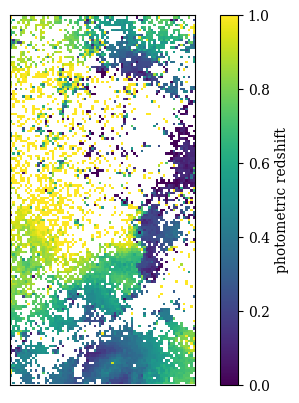

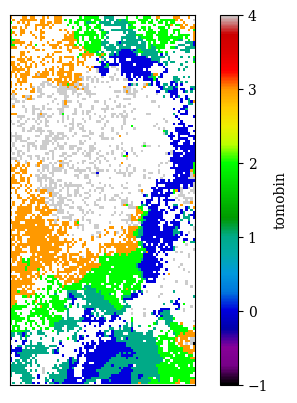

In [64]:
#validate that we're doing it right
print(cosmoslike_cat.shape)
print([col for col in cosmoslike_cat.columns])

mask = np.isnan(cosmoslike_cat['PHOTZ'])|(cosmoslike_cat['PHOTZ']<-1)
unqcells,medianzs,stds,ct = get_cell_medians(cosmoslike_cat[~mask]['PHOTZ'],cosmoslike_cat[~mask]['CELLINDEX'])
unqcells,tomo,stds,ct = get_cell_medians(cosmoslike_cat[~mask]['tomobin'],cosmoslike_cat[~mask]['CELLINDEX'])

somzs_cosmoslike = format_cell_props(unqcells,medianzs)
somcts_cosmoslike = format_cell_props(unqcells,ct)
somtomo_cosmoslike = format_cell_props(unqcells,tomo)

plt.imshow(somzs_cosmoslike,origin='lower',interpolation='nearest',vmin=0,vmax=1)
plt.xticks([])
plt.yticks([])
plt.colorbar(label='photometric redshift')
plt.show()
plt.imshow(somtomo_cosmoslike,origin='lower',interpolation='nearest',cmap='nipy_spectral')
plt.xticks([])
plt.yticks([])
plt.colorbar(label='tomobin')
plt.show()

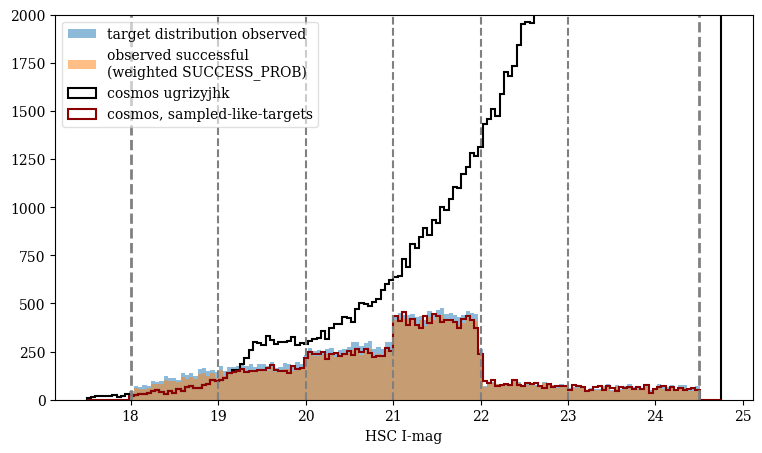

In [23]:
plt.figure(figsize=(9,5))
bins = np.linspace(17.5,24.75,num=150)
plt.hist(cat['I_MAG'],bins=bins,alpha=0.5, label='target distribution observed',density=False)
plt.hist(cat['I_MAG'],bins=bins,alpha=0.5,label='observed successful\n(weighted SUCCESS_PROB)',weights=cat['SUCCESS_PROB'],density=False)

plt.hist(cosmos['I'], bins=bins, color='black',histtype='step',linewidth=1.5,alpha=1.0,label='cosmos ugrizyjhk',#\n(weighted SUCCESS_PROB)',
         density=False, weights=np.ones(len(cosmos['I'])))

plt.hist(cosmoslike_cat['I'], bins=bins, color='darkred',histtype='step',linewidth=1.5,alpha=1.0,label='cosmos, sampled-like-targets',#\n(weighted SUCCESS_PROB)',
         density=False, weights=np.ones(len(cosmoslike_cat['I'])))
plt.xlabel('HSC I-mag')
plt.axvline(x=24.5,linestyle='dashed',color='gray',linewidth=2)
plt.axvline(x=23.0,linestyle='dashed',color='gray')
plt.axvline(x=22.0,linestyle='dashed',color='gray')
plt.axvline(x=21.0,linestyle='dashed',color='gray')
plt.axvline(x=20.0,linestyle='dashed',color='gray')
plt.axvline(x=19.0,linestyle='dashed',color='gray')
plt.axvline(x=18.0,linestyle='dashed',color='gray',linewidth=2)
plt.legend(loc='upper left',frameon=True, framealpha=0.6)
plt.ylim([0,2000])
plt.show()

# Look at SOM coverage of the matched sample

In [24]:
def format_cell_props(unqcells,prop,shp=(150,75)):
    #function takes unique cell ids and property vectors and reshapes it into a SOM array that is NaN where undefined, for plotting
    output = np.ones(shp[0]*shp[1])*np.NaN
    for i,c in enumerate(unqcells):
        output[c] = prop[i]
        
    return np.reshape(output,shp)

def get_coverage(cellids,shp=(150,75)):
    #get cell occupancy, return SOM object formatted correctly
    unqcells, cts = np.unique(cellids,return_counts=True)
    output = format_cell_props(unqcells,cts,shp=shp)
    output[np.isnan(output)] = 0 #its occupancy, so this is valid
    return output

def get_neff_coverage(cellids, succ_prob, shp=(150,75)):
    #get cell occupancy by summing the success probability per object, return SOM object formatted correctly
    unqcells = np.unique(cellids)
    cts = np.array([np.sum(succ_prob[cellids==cell]) for cell in unqcells])
    output = format_cell_props(unqcells,cts,shp=shp)
    output[np.isnan(output)] = 0 #its occupancy, so this is valid
    return output

/tmp/ipykernel_2289772/1177210343.py:13: RuntimeWarning: divide by zero encountered in divide
  img = ax[2].imshow(occup_cosmos/occup,origin='lower',interpolation='nearest',cmap='binary',vmin=0,vmax=5)
/tmp/ipykernel_2289772/1177210343.py:13: RuntimeWarning: invalid value encountered in divide
  img = ax[2].imshow(occup_cosmos/occup,origin='lower',interpolation='nearest',cmap='binary',vmin=0,vmax=5)


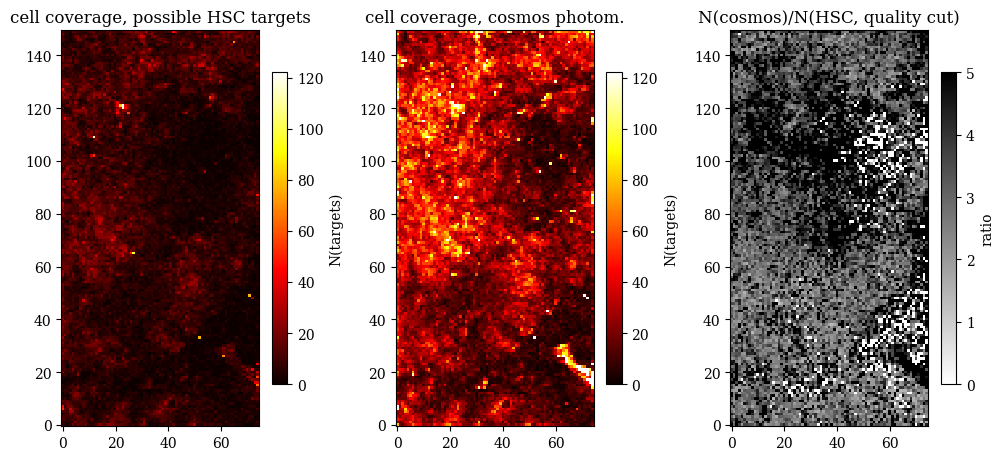

In [25]:
occup = get_coverage(matched_targets['CELLINDEX'])
occup_cosmos = get_coverage(cosmos['CELLINDEX'])

fig,ax = plt.subplots(1,3,figsize=(10,5))
img = ax[0].imshow(occup,origin='lower',interpolation='nearest',cmap='hot')
ax[0].set_title('cell coverage, possible HSC targets')
plt.colorbar(img, ax=ax[0],label='N(targets)',shrink=0.7)

img = ax[1].imshow(occup_cosmos,origin='lower',interpolation='nearest',cmap='hot',vmin=0,vmax=np.max(occup))
ax[1].set_title('cell coverage, cosmos photom.')
plt.colorbar(img, ax=ax[1],label='N(targets)',shrink=0.7)

img = ax[2].imshow(occup_cosmos/occup,origin='lower',interpolation='nearest',cmap='binary',vmin=0,vmax=5)
ax[2].set_title('N(cosmos)/N(HSC, quality cut)')
plt.colorbar(img, ax=ax[2],label='ratio',shrink=0.7)

plt.tight_layout()
plt.show()

for stage 3 cosmos overlap, we have:
	~4025 successful objects
	2638 filled cells, 23.45% of color space for LSST+Euclid


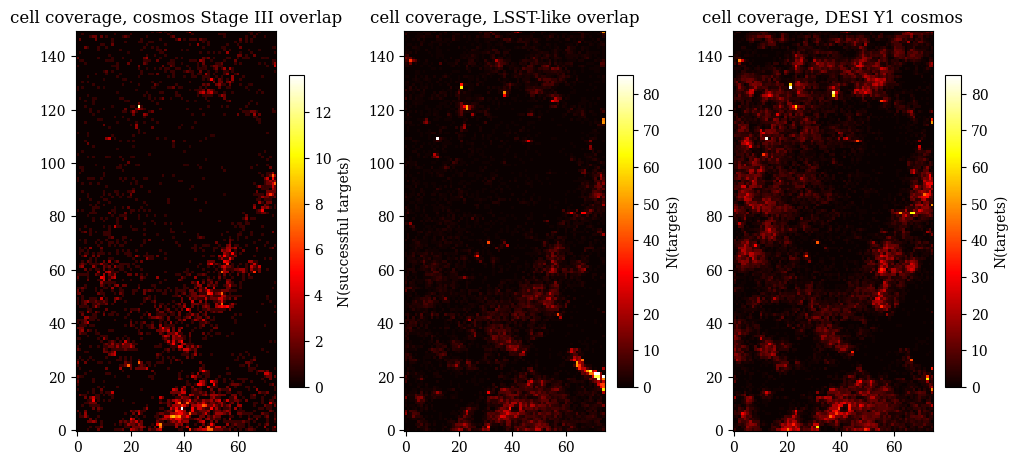

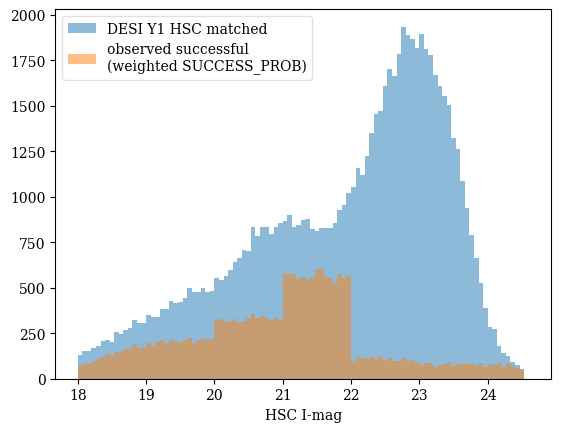

In [51]:
#now do mock up of (1) wide LSST DDF coverage (2) Stage III coverage (COSMOS only), (3) existing coverage from COSMOS/XMM Y1

occup_stage3 = get_neff_coverage(matched_obs['CELLINDEX'],matched_obs['SUCCESS_PROB'])
occup_desiy1 = get_coverage(matched_desiy1['CELLINDEX'])
occup_lsst = get_coverage(cosmoslike_cat['CELLINDEX'])

print('for stage 3 cosmos overlap, we have:')
print('\t~{0} successful objects'.format(round(np.sum(occup_stage3.flatten()))))
totcells = np.sum(occup_stage3.flatten()>0)
print('\t{0:d} filled cells, {1:.2f}% of color space for LSST+Euclid'.format(totcells, 100*totcells/(150.*75.)))

fig,ax = plt.subplots(1,3,figsize=(10,5))
img = ax[0].imshow(occup_stage3,origin='lower',interpolation='nearest',cmap='hot')
ax[0].set_title('cell coverage, cosmos Stage III overlap')
plt.colorbar(img, ax=ax[0],label='N(successful targets)',shrink=0.7)

img = ax[1].imshow(occup_lsst,origin='lower',interpolation='nearest',cmap='hot',vmin=0,vmax=np.max(occup_desiy1))
ax[1].set_title('cell coverage, LSST-like overlap')
plt.colorbar(img, ax=ax[1],label='N(targets)',shrink=0.7)

img = ax[2].imshow(occup_desiy1,origin='lower',interpolation='nearest',cmap='hot',vmin=0,vmax=np.max(occup_desiy1))
ax[2].set_title('cell coverage, DESI Y1 cosmos')
plt.colorbar(img, ax=ax[2],label='N(targets)',shrink=0.7)

plt.tight_layout()
plt.show()

density = False
plt.hist(matched_desiy1_hsc['I_MAG'],bins=bins,alpha=0.5,label='DESI Y1 HSC matched',density=density)
plt.hist(cat['I_MAG'],bins=bins,alpha=0.5,label='observed successful\n(weighted SUCCESS_PROB)',weights=cat['SUCCESS_PROB'],density=density)
plt.xlabel('HSC I-mag')
plt.legend(loc='upper left',frameon=True, framealpha=0.6)
#plt.ylim([0,2000])
plt.show()

In [57]:
mask = np.isnan(cosmos['PHOTZ'])|(cosmos['PHOTZ']<-1)
unqcells,medianzs,stds,ct = get_cell_medians(cosmos[~mask]['PHOTZ'],cosmos[~mask]['CELLINDEX'])
unqcells,tomos_cell,stds,ct = get_cell_medians(cosmos_bins[~mask],cosmos[~mask]['CELLINDEX'])

somzs = format_cell_props(unqcells,medianzs)
somcts = format_cell_props(unqcells,ct)
somtomo = format_cell_props(unqcells,tomos_cell)

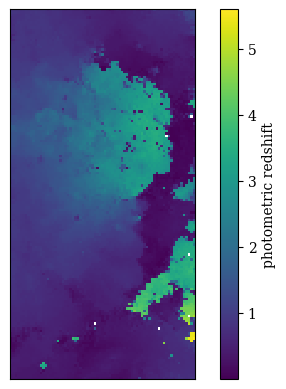

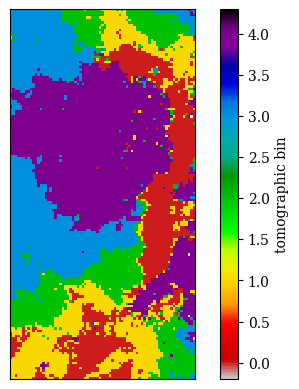

/tmp/ipykernel_2289772/2287002769.py:15: RuntimeWarning: divide by zero encountered in divide
  vals = occup_lsst/occup_desiy1
/tmp/ipykernel_2289772/2287002769.py:15: RuntimeWarning: invalid value encountered in divide
  vals = occup_lsst/occup_desiy1
/tmp/ipykernel_2289772/2287002769.py:20: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(occup_lsst/occup_desiy1,origin='lower',interpolation='nearest',vmin=minval,vmax=maxval,cmap='hot')
/tmp/ipykernel_2289772/2287002769.py:20: RuntimeWarning: invalid value encountered in divide
  plt.imshow(occup_lsst/occup_desiy1,origin='lower',interpolation='nearest',vmin=minval,vmax=maxval,cmap='hot')


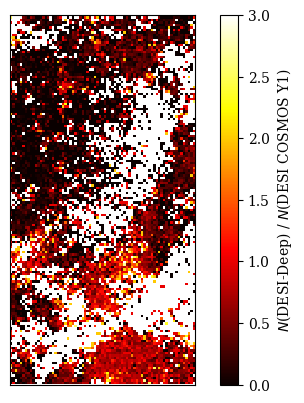

In [62]:
plt.imshow(somzs,origin='lower',interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.colorbar(label='photometric redshift')
plt.savefig('./figures/photoz_som.pdf',dpi=300,bbox_inches='tight')
plt.show()

plt.imshow(somtomo,origin='lower',interpolation='nearest',cmap='nipy_spectral_r',vmin=-0.2,vmax=4.3)
plt.xticks([])
plt.yticks([])
plt.colorbar(label='tomographic bin')
plt.savefig('./figures/tomo_som.pdf',dpi=300,bbox_inches='tight')
plt.show()

vals = occup_lsst/occup_desiy1
maxval=3
minval=0
mask = np.isinf(vals)
vals[mask] = maxval
plt.imshow(occup_lsst/occup_desiy1,origin='lower',interpolation='nearest',vmin=minval,vmax=maxval,cmap='hot')
plt.xticks([])
plt.yticks([])
plt.colorbar(label=r'$N$(DESI-Deep) / $N$(DESI COSMOS Y1)')
plt.savefig('./figures/deep_versus_y1_fraction_som.pdf',dpi=300,bbox_inches='tight')
plt.show()

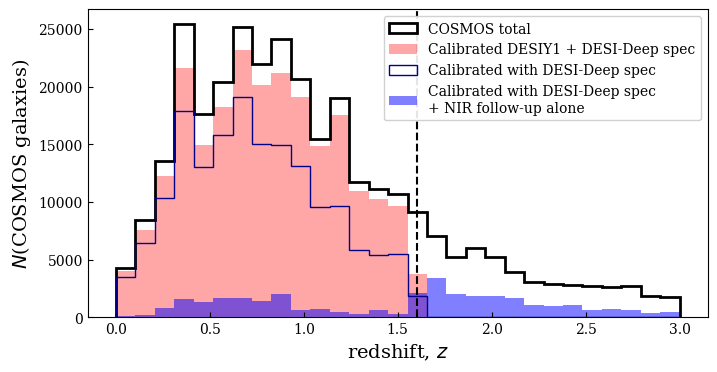

In [29]:
#alternatively show number of calibrators as a function of z or i mag
bins = np.linspace(0,3,num=30)
plt.figure(figsize=(8,4))
plt.hist(somzs.flatten(),bins=bins,color='black',histtype='step',linewidth=2,label='COSMOS total',weights=somcts.flatten() )
mask = ((occup_lsst+occup_desiy1) > 0)&(somzs <=1.6)
plt.hist(somzs[mask].flatten(),bins=bins,color='red',histtype='stepfilled',alpha=0.35,label='Calibrated DESIY1 + DESI-Deep spec',weights=somcts[mask].flatten())

mask1 = (occup_desiy1 > 0)&(somzs <=1.6)
#plt.hist(somzs[mask1].flatten(),bins=bins,color='red',histtype='stepfilled',alpha=0.35,label='Calibrated with DESIY1 spec',weights=somcts[mask1].flatten())
mask = (occup_lsst > 0)&(somzs <=1.6)
plt.hist(somzs[mask].flatten(),bins=bins,color='darkblue',histtype='step',linewidth=1,label='Calibrated with DESI-Deep spec',weights=somcts[mask].flatten())

mask = (occup_lsst > 0) & ~(mask1)
plt.hist(somzs[mask].flatten(),bins=bins,color='blue',histtype='stepfilled',alpha=0.5,label='Calibrated with DESI-Deep spec\n+ NIR follow-up alone',weights=somcts[mask].flatten())

plt.legend(loc='upper right',frameon=True,framealpha=0.9)
plt.xlabel(r'redshift, $z$',fontsize=14)
plt.ylabel(r'$N$(COSMOS galaxies)',fontsize=14)
plt.axvline(x=1.6,linestyle='dashed',color='black')
ax = plt.gca()
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
#plt.yscale('log')
plt.savefig('./figures/redshift_calibration_hist.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [30]:
#alternatively show number of calibrators as a function of z or i mag
mask = np.isnan(cosmos['I'])|(cosmos['PHOTZ']<-1)
unqcells,medianzs,stds,ct = get_cell_medians(cosmos[~mask]['I'],cosmos[~mask]['CELLINDEX'])
somis = format_cell_props(unqcells,medianzs)
somcts = format_cell_props(unqcells,ct)

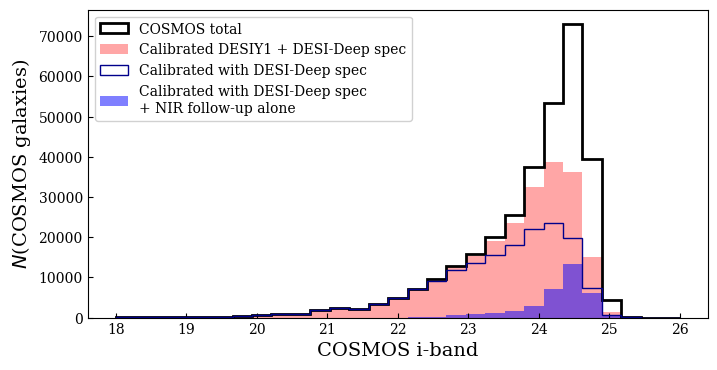

In [31]:
bins = np.linspace(18,26,num=30)
plt.figure(figsize=(8,4))
plt.hist(somis.flatten(),bins=bins,color='black',histtype='step',linewidth=2,label='COSMOS total',weights=somcts.flatten() )
mask = ((occup_lsst+occup_desiy1) > 0)&(somzs <=1.6)
plt.hist(somis[mask].flatten(),bins=bins,color='red',histtype='stepfilled',alpha=0.35,label='Calibrated DESIY1 + DESI-Deep spec',weights=somcts[mask].flatten())

mask1 = (occup_desiy1 > 0)&(somzs <=1.6)
#plt.hist(somzs[mask1].flatten(),bins=bins,color='red',histtype='stepfilled',alpha=0.35,label='Calibrated with DESIY1 spec',weights=somcts[mask1].flatten())
mask = (occup_lsst > 0)&(somzs <=1.6)
plt.hist(somis[mask].flatten(),bins=bins,color='darkblue',histtype='step',linewidth=1,label='Calibrated with DESI-Deep spec',weights=somcts[mask].flatten())

mask = (occup_lsst > 0) & ~(mask1)
plt.hist(somis[mask].flatten(),bins=bins,color='blue',histtype='stepfilled',alpha=0.5,label='Calibrated with DESI-Deep spec\n+ NIR follow-up alone',weights=somcts[mask].flatten())

plt.legend(loc='upper left',frameon=True,framealpha=0.9)
plt.xlabel(r'COSMOS i-band',fontsize=14)
plt.ylabel(r'$N$(COSMOS galaxies)',fontsize=14)
#plt.axvline(x=1.6,linestyle='dashed',color='black')
ax = plt.gca()
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
#plt.yscale('log')
plt.savefig('./figures/imag_calibration_hist.pdf',dpi=300,bbox_inches='tight')
plt.show()

for stage iv overlap (estimated with cosmos photometry), we estimate 5.617% of galaxies observed have z > 1.6

for stage iii overlap with cosmos photometry, we estimate 2.349% of galaxies observed have z > 1.6
for stage iii overlap with cosmos photometry AND I > 23, we estimate 16.071% of galaxies observed have z > 1.6
we estimate that amounts to 1999.444 fiber hours spent on unsuccessful targets or 0.090 fractionally.



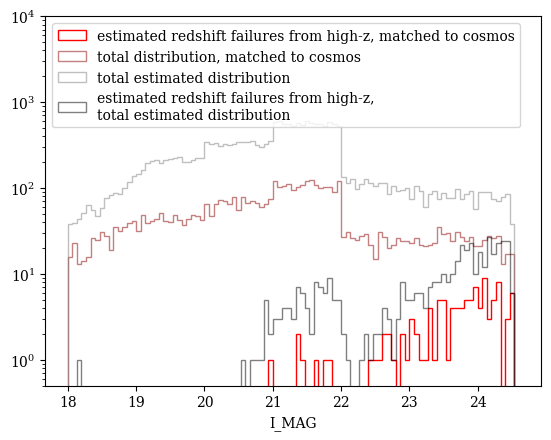

(99,)
(99,)
[18.03333333333333, 18.1, 18.166666666666664, 18.233333333333334, 18.299999999999997, 18.366666666666667, 18.433333333333334, 18.5, 18.56666666666667, 18.633333333333333, 18.700000000000003, 18.766666666666666, 18.833333333333336, 18.9, 18.96666666666667, 19.03333333333333, 19.1, 19.166666666666664, 19.233333333333334, 19.299999999999997, 19.366666666666667, 19.433333333333334, 19.5, 19.56666666666667, 19.633333333333333, 19.700000000000003, 19.766666666666666, 19.833333333333336, 19.9, 19.96666666666667, 20.03333333333333, 20.1, 20.166666666666664, 20.233333333333334, 20.3, 20.366666666666667, 20.433333333333334, 20.5, 20.56666666666667, 20.633333333333333, 20.700000000000003, 20.766666666666666, 20.833333333333336, 20.9, 20.96666666666667, 21.03333333333333, 21.1, 21.166666666666664, 21.233333333333334, 21.3, 21.366666666666667, 21.433333333333337, 21.5, 21.56666666666667, 21.633333333333333, 21.700000000000003, 21.766666666666666, 21.833333333333336, 21.9, 21.96666666666

/tmp/ipykernel_2289772/1567050981.py:39: RuntimeWarning: invalid value encountered in divide
  plt.plot(binmids,hists5[0]/hists6[0],'o-',color='black',linewidth=1,markersize=0.5)
/tmp/ipykernel_2289772/1567050981.py:43: RuntimeWarning: invalid value encountered in divide
  print(hists5[0]/hists6[0])


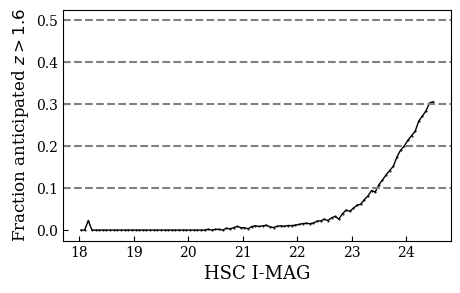

In [32]:
# let's estimate which ones have a photo-z > 1.6

mask1 = (cosmoslike_cat['PHOTZ'] >= 1.6)
print('for stage iv overlap (estimated with cosmos photometry), we estimate {0:.3f}% of galaxies observed have z > 1.6\n'.format(mask.sum()/len(cosmoslike_cat)*100))
#print('we estimate that amounts to {0:.3f} fiber hours spent on unsuccessful targets.\n'.format(cosmoslike_cat[mask]['EXP_TIME'].sum()/3600.))

mask = (matched_obs['PHOTZ'] >= 1.6)
mask2 = (matched_obs['I_MAG'] >= 23)

print('for stage iii overlap with cosmos photometry, we estimate {0:.3f}% of galaxies observed have z > 1.6'.format(mask.sum()/len(matched_obs)*100))
print('for stage iii overlap with cosmos photometry AND I > 23, we estimate {0:.3f}% of galaxies observed have z > 1.6'.format((mask&mask2).sum()/(mask2).sum()*100))

print('we estimate that amounts to {0:.3f} fiber hours spent on unsuccessful targets or {1:0.3f} fractionally.\n'.format(np.sum(matched_obs[mask]['EXP_TIME'])/3600.,
                                                                                                                        np.sum(matched_obs[mask]['EXP_TIME'])/np.sum(matched_obs['EXP_TIME'])))

bins=np.linspace(18,24.6,num=100)
hists = plt.hist(matched_obs[mask]['I_MAG'],bins=bins,histtype='step',color='red',label='estimated redshift failures from high-z, matched to cosmos')
hists2 = plt.hist(matched_obs['I_MAG'],bins=bins,histtype='step',color='darkred',alpha=0.5,label='total distribution, matched to cosmos')
hists3 = plt.hist(cosmoslike_cat['I'],bins=bins,histtype='step',color='grey',alpha=0.5,label='total estimated distribution')
hists4 = plt.hist(cosmoslike_cat[mask1]['I'],bins=bins,histtype='step',color='black',alpha=0.5,label='estimated redshift failures from high-z,\ntotal estimated distribution')

plt.xlabel('I_MAG')
plt.legend(loc='upper left')
plt.yscale('log')
plt.ylim([0.5,10**4])
plt.show()

mask3 = (cosmos['I'] < 24.5)
mask4 = (cosmos['PHOTZ'] > 1.6)
hists5 = np.histogram(cosmos[mask3&mask4]['I'],bins=bins)
hists6 = np.histogram(cosmos[mask3]['I'],bins=bins)

print(hists[0].shape)
print(hists2[0].shape)
binmids = [(bins[i]+bins[i+1])/2 for i in np.arange(len(bins)-1)]
plt.figure(figsize=(5,3))
# plt.plot(binmids,hists[0]/hists2[0],'o-',color='gray',linewidth=0.5,markersize=0.5)
# plt.plot(binmids,hists4[0]/hists3[0],'o-',color='gray',linewidth=0.5,markersize=0.5)
plt.plot(binmids,hists5[0]/hists6[0],'o-',color='black',linewidth=1,markersize=0.5)


print(binmids)
print(hists5[0]/hists6[0])
plt.xlabel(r'HSC I-MAG',fontsize=13)
plt.ylabel(r'Fraction anticipated $z > 1.6$',fontsize=12)
#plt.axhline(y=1,linestyle='dashed',color='gray')
plt.axhline(y=0.5,linestyle='dashed',color='gray')
plt.axhline(y=0.4,linestyle='dashed',color='gray')
plt.axhline(y=0.3,linestyle='dashed',color='gray')
plt.axhline(y=0.2,linestyle='dashed',color='gray')
plt.axhline(y=0.1,linestyle='dashed',color='gray')
plt.savefig('./figures/redshift_incompleteness.pdf',dpi=300,bbox_inches='tight')

ax = plt.gca()
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")

plt.show()


# Get some tomographic binnings set up to look at number of calibrators ending up in each bin

In [33]:
#write a function to get equal tomobins defined as a hash table
def get_equal_tomobins(abund,medianzs,nbins=5,iterate=True,verbose=True):
    #function takes a cell abundance input and cell median-zs and returns a hashtable for cell-tomo assignment with nbins
    #medianz is an array of unique cell, median z, cell standard deviation, and cell count in the shape N x 4
    #abund is a tuple of length 2, with (cellid, abundance)
    
    
    #sort the cellids so theyre ascending (default)
    medianzs = medianzs[medianzs[:,0].argsort(), :] 
    #find cells where we have both spec and abundance measurements
    newmed = medianzs[np.in1d(medianzs[:,0],abund[0]),:]
    abundance = abund[1][np.in1d(abund[0],medianzs[:,0])].T
    if verbose:
        print('we have {} unique cells in both abundance and spec.'.format(unqcells.shape))
    
    newmed = np.column_stack((newmed,abundance)) #newmed is now unq cell, med z, sig z cell, cell count spec, cell abundance targets
   
    #sort the medianzs so theyre ascending
    newmed = newmed[newmed[:,1].argsort(), :] 
    print(newmed[:,1])
    tot_gal = float(np.sum(newmed[:,-1])) #summed over abundance
    gals_per_bin = round(tot_gal/nbins)
    if verbose:
        print('for {0} bins we want approx {1} gals per bin'.format(nbins,gals_per_bin))
        
    #now we simply iterate the best we can forward
    tomobins={}
    zinit=0.0
    for b in np.arange(nbins):
        #for each tomo bin
        subset = newmed[np.where(newmed[:,1] > zinit)] #pick the subset at the redshift above the last cutoff
        i = 0
        if verbose:
            print('on bin {}...'.format(b))
            print(zinit)
        while (np.sum(subset[:i,4]) < gals_per_bin) & (i < len(subset)): #iterate until we reach how many galaxies need to be in this bin or there are no more
            i = i +1
        
        tomobins[b] = subset[:i,0] #assign cell ids to the tomographic bin
        try:
            zinit = subset[i,1] #next bin cutoff
        except:
            zinit = subset[i-1,1] #last object in array

    return tomobins

def get_constrain_tomobins(abund,medianzs,edges=[0.,0.35,0.55,0.75,1.2,6],verbose=True):
    #function takes a cell abundance input and cell median-zs and returns a hashtable for cell-tomo assignment with nbins
    #medianz is an array of unique cell, median z, cell standard deviation, and cell count in the shape N x 4
    # if given bin edges, will use them to define bins
    #abund is a tuple of length 2, with (cellid, abundance)

    nbins=len(edges)-1
    
    #sort the cellids so theyre ascending (default)
    medianzs = medianzs[medianzs[:,0].argsort(), :] 
    #find cells where we have both spec and abundance measurements
    newmed = medianzs[np.in1d(medianzs[:,0],abund[0]),:]
    abundance = abund[1][np.in1d(abund[0],medianzs[:,0])].T
    if verbose:
        print('we have {} unique cells in both abundance and spec.'.format(unqcells.shape))
    
    newmed = np.column_stack((newmed,abundance)) #newmed is now unq cell, med z, sig z cell, cell count spec, cell abundance targets
   
    #sort the medianzs so theyre ascending
    newmed = newmed[newmed[:,1].argsort(), :] 
    print(newmed[:,1])
    tot_gal = float(np.sum(newmed[:,-1])) #summed over abundance
    gals_per_bin = round(tot_gal/nbins)
        
    #now we simply iterate the best we can forward
    tomobins={}
    zinit=0.0
    for b in np.arange(nbins):
        #for each tomo bin
        subset = newmed[np.where(newmed[:,1] > edges[b])] #pick the subset at the redshift above the last cutoff
        i = 0
        if verbose:
            print('on bin {}...'.format(b))

        while (subset[i,1] < edges[b+1]): #iterate until we reach how many galaxies need to be in this bin or there are no more
            if i == (len(subset[:,1])-1):
                #if we're at the end of the stuff leave loop
                break
            i = i +1
            
        tomobins[b] = subset[:i,0] #assign cell ids to the tomographic bin

    return tomobins
    
def assign_tomo_bins(cellids,tomobindict):
    #uses numpy hash table to assign tomographic bins from a dictionary (1:[cellidarray],2:[cellidarray]...) to a vector of cellids
    
    cellids = pd.Series(cellids)
    tmp_cells = np.concatenate([tomobindict[nbin] for nbin in tomobindict])
    tmp_bins = np.concatenate([(np.ones(len(tomobindict[nbin])) * nbin).astype(int) for nbin in tomobindict])

    tomo_bin_hashtable_equal = pd.Series(tmp_bins, tmp_cells)

    binums = cellids.map(tomo_bin_hashtable_equal)
    binums[binums.isna()] = -1
    
    return binums.astype(int)


def assign_abundance_weight(cellids,abund):
    #do mapping instead of pandas merge
    
    abunddict = {abund[0][i]:abund[1][i] for i in np.arange(len(abund[0]))}
    cellids = pd.DataFrame(cellids,columns=['cellid'])
    weights = cellids['cellid'].map(abunddict)
    return weights

In [34]:
matched_obs.columns

Index(['RA', 'DEC', 'I_MAG', 'NASSIGN', 'NGOAL', 'EXP_TIME', 'SUBPRIORITY',
       'SUCCESS_PROB', 'ID', 'XP', 'YP', 'R2', 'R2_LAIGLE', 'I_FLAG', 'K_FLAG',
       'SOURCE', 'UTOT', 'GTOT', 'RTOT', 'ITOT_1', 'ZTOT', 'YTOT', 'JTOT',
       'HTOT', 'KSTOT', 'UTERR', 'GTERR', 'RTERR', 'ITERR', 'ZTERR', 'YTERR',
       'JTERR', 'HTERR', 'KSTERR', 'U', 'G', 'R', 'I', 'Z', 'Y', 'J', 'H',
       'KS', 'UERR', 'GERR', 'RERR', 'IERR', 'ZERR', 'YERR', 'JERR', 'HERR',
       'KSERR', 'E_B_V_', 'RIZ', 'RIZERR', 'INSTR', 'PHOTZ', 'CELLINDEX',
       'CELLX', 'CELLY', 'SEP', 'HOUR', 'MINUTE', 'SECOND', 'DEGREE', 'AMIN',
       'ASEC', 'tomobin', 'abund', 'weight_to_cosmos', 'med_spec_z'],
      dtype='object')

In [35]:
# for reweighting back to cosmos with the Stage III overlap
#use the median zs
mask = np.isnan(cosmos['PHOTZ'])|(cosmos['PHOTZ']<-1)
unqcells,medianzs,stds,ct = get_cell_medians(cosmos[~mask]['PHOTZ'],cosmos[~mask]['CELLINDEX'])
medzs = np.vstack((unqcells,medianzs,stds,ct)).T

abund_cosmos = count_in_c(cosmos[~mask]['CELLINDEX'])
print(abund_cosmos)

(array([    0,     1,     2, ..., 11247, 11248, 11249], dtype='>i2'), array([58, 18, 13, ..., 90, 61, 76]))


In [36]:
# assign the tomobins to the wider cosmos
tomobin_dict = get_constrain_tomobins(abund_cosmos,medzs,verbose=True)
matched_obs['tomobin'] = assign_tomo_bins(matched_obs['CELLINDEX'].values,tomobin_dict)

cosmos_bins = assign_tomo_bins(cosmos['CELLINDEX'],tomobin_dict)

matched_desiy1['tomobin'] = assign_tomo_bins(matched_desiy1['CELLINDEX'],tomobin_dict)

we have (11244,) unique cells in both abundance and spec.
[4.99999989e-03 5.10000018e-03 5.10000018e-03 ... 5.44120026e+00
 5.45359993e+00 5.59509993e+00]
on bin 0...
on bin 1...
on bin 2...
on bin 3...
on bin 4...


In [37]:
matched_obs['abund'] = assign_abundance_weight(matched_obs['CELLINDEX'].values, abund_cosmos)
matched_obs['weight_to_cosmos'] = np.NaN #initialize
matched_obs['med_spec_z'] = np.NaN #initialize

for cell in np.unique(matched_obs['CELLINDEX'].values):
    cond = (matched_obs['CELLINDEX'] == cell)
    matched_obs.loc[cond,'weight_to_cosmos'] = matched_obs[cond]['abund']/float(cond.sum())
    mask = np.in1d((medzs[:,0]),int(cell))
    assert(mask.sum()==1)
    matched_obs.loc[cond,'med_spec_z'] = float(medzs[mask,1])
print('weights calculated!')

/tmp/ipykernel_2289772/3868824297.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matched_obs.loc[cond,'med_spec_z'] = float(medzs[mask,1])
/tmp/ipykernel_2289772/3868824297.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matched_obs.loc[cond,'med_spec_z'] = float(medzs[mask,1])
/tmp/ipykernel_2289772/3868824297.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matched_obs.loc[cond,'med_spec_z'] = float(medzs[mask,1])
/tmp/ipykernel_2289772/3868824297.

weights calculated!


/tmp/ipykernel_2289772/3868824297.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matched_obs.loc[cond,'med_spec_z'] = float(medzs[mask,1])
/tmp/ipykernel_2289772/3868824297.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matched_obs.loc[cond,'med_spec_z'] = float(medzs[mask,1])
/tmp/ipykernel_2289772/3868824297.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matched_obs.loc[cond,'med_spec_z'] = float(medzs[mask,1])
/tmp/ipykernel_2289772/3868824297.

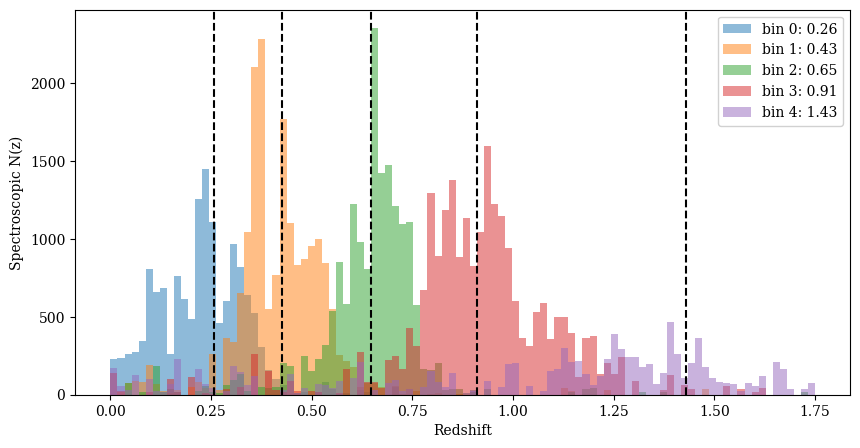

In [39]:
sigma = 1.0

# plt.figure(figsize=(10,5))
# for b in np.arange(np.max(matched_obs['tomobin'].values)+1):
#     specbin = matched_obs[(matched_obs['tomobin'] == b)]
#     plt.hist(specbin['PHOTZ'].values,bins=100,range=(0,1.75),alpha=0.5,label='bin {0}: {1:.2f}'.format(str(b),np.nanmean(specbin['PHOTZ'].values)))
#     plt.axvline(x=np.nanmean(specbin['PHOTZ'].values),linestyle='dashed',label=None)
           
# plt.xlabel('Redshift')
# plt.ylabel('Spectroscopic N(z)')
# plt.legend(loc='upper right')
# plt.show()

plt.figure(figsize=(10,5))
for b in np.arange(np.max(matched_obs['tomobin'].values)+1):
    specbin = matched_obs[(matched_obs['tomobin'] == b)&(matched_obs['PHOTZ']>0)]
    #eliminate nans
    mask = (~np.isnan(specbin['PHOTZ'].values))&(~np.isnan(specbin['weight_to_cosmos'].values))
    wghtedmean = np.average(specbin[mask]['PHOTZ'].values, weights = specbin[mask]['weight_to_cosmos'].values)
    plt.hist(specbin[mask]['PHOTZ'].values,bins=100,range=(0,1.75),alpha=0.5,weights=specbin[mask]['weight_to_cosmos'],label='bin {0}: {1:.2f}'.format(str(b),wghtedmean))
    plt.axvline(x=wghtedmean,linestyle='dashed',color='black',label=None)
           
plt.xlabel('Redshift')
plt.ylabel('Spectroscopic N(z)')
plt.legend(loc='upper right',frameon=True,framealpha=0.9)
plt.show()

In [65]:
#get some statistics:
def get_bin_statistics(tomobin_ind,label=None):
    if label is not None:
        print(label)
    unq,cts = np.unique(tomobin_ind,return_counts=True)
    print('overall we have {0} objects'.format(len(tomobin_ind)))
    
    for i,b in enumerate(unq):
        if (b == -1)|np.isnan(b):
            continue
        print('\t in bin {0} we have {1} objects'.format(int(b+1), cts[i]))
    return unq,cts

In [66]:
obs_statsiii = get_bin_statistics(matched_obs['tomobin'].values,label='For Stage III photometry matched DESI-Deep...')
obs_statsiv = get_bin_statistics(cosmoslike_cat['tomobin'].values,label='For Stage IV photometry matched DESI-Deep...')
obs_statsy1 = get_bin_statistics(matched_desiy1['tomobin'].values,label='For Stage III photometry matched DESI-Y1...')
obs_statsall = get_bin_statistics(pd.concat([matched_desiy1['tomobin'],cosmoslike_cat['tomobin']]),label='For Stage III photometry matched DESI-Y1 and IV matched to DESI-Deep...')


For Stage III photometry matched DESI-Deep...
overall we have 4598 objects
	 in bin 1 we have 1290 objects
	 in bin 2 we have 1267 objects
	 in bin 3 we have 877 objects
	 in bin 4 we have 847 objects
	 in bin 5 we have 316 objects
For Stage IV photometry matched DESI-Deep...
overall we have 21077 objects
	 in bin 1 we have 5392 objects
	 in bin 2 we have 5277 objects
	 in bin 3 we have 4162 objects
	 in bin 4 we have 4243 objects
	 in bin 5 we have 1963 objects
For Stage III photometry matched DESI-Y1...
overall we have 43053 objects
	 in bin 1 we have 10603 objects
	 in bin 2 we have 7654 objects
	 in bin 3 we have 5792 objects
	 in bin 4 we have 9892 objects
	 in bin 5 we have 9092 objects
For Stage III photometry matched DESI-Y1 and IV matched to DESI-Deep...
overall we have 64130 objects
	 in bin 1 we have 15995 objects
	 in bin 2 we have 12931 objects
	 in bin 3 we have 9954 objects
	 in bin 4 we have 14135 objects
	 in bin 5 we have 11055 objects


{0: array([ 9487.,  9412.,  6209., ..., 10394.,  1386.,  1699.]), 1: array([ 920., 1072.,  571., ..., 1583.,  433., 1743.]), 2: array([  960.,  2197., 11069., ...,  3023.,  3945.,  2335.]), 3: array([10674.,  2337.,  3947., ...,  4845.,  8179.,  4970.]), 4: array([4530., 4968., 5938., ..., 1424., 1273., 1198.])}


(array([  40.,    0., 5392.,    0., 5277.,    0., 4162.,    0., 4243.,
        1963.]),
 array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]),
 <BarContainer object of 10 artists>)

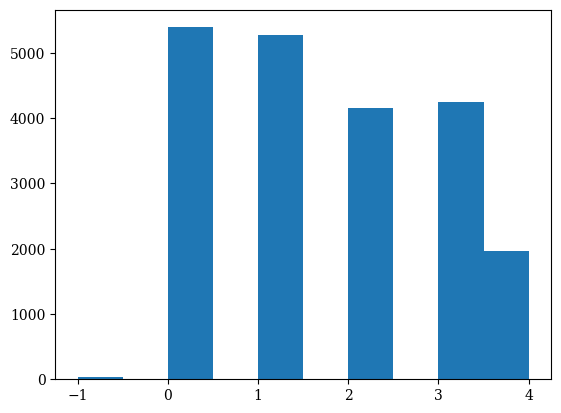

In [67]:
print(tomobin_dict)
plt.hist(cosmoslike_cat['tomobin'].values)

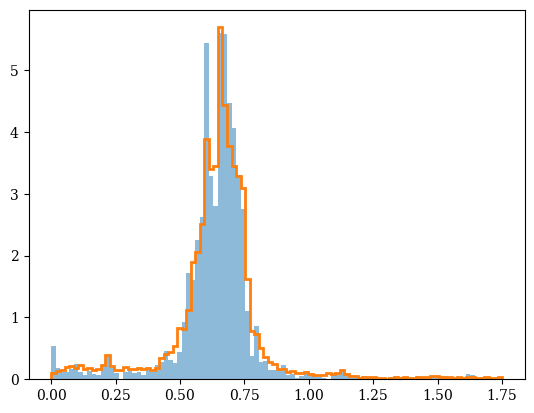

In [72]:
#some debugging
mask = (cosmoslike_cat['tomobin']==2)
plt.hist(cosmoslike_cat[mask]['PHOTZ'].values,bins=100,range=(0,1.75),alpha=0.5,density=True)
mask = np.where(cosmos_bins == 2)
plt.hist(cosmos[mask]['PHOTZ'],bins=100,range=(0,1.75),histtype='step',linewidth=2,density=True)
plt.show()

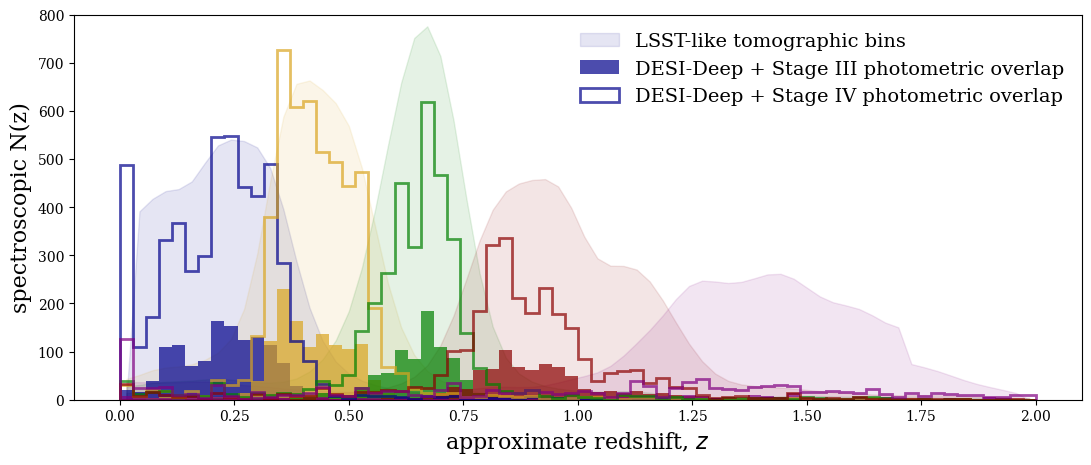

In [159]:
#let's plot the spec contributions from each of them given some weights
sigma = 1.5
uplim = 2.
nbins=70
scaling = 200

plt.figure(figsize=(13,5))
ax1 = plt.gca()

colors = ['darkblue','goldenrod','green','darkred','purple']
linetype = ['solid','dashed','dotted']
histtype = ['stepfilled','step','step']

for b in np.arange(np.nanmax(cosmos_bins)+1): #the cosmos stuff 'wide bins'
    specbin = cosmos[(cosmos_bins == b)&(cosmos['PHOTZ']>0)]
    #eliminate nans, no weighting
    mask = (~np.isnan(specbin['PHOTZ']))#&(~np.isnan(specbin['weight_to_cosmos'].values))
    #wghtedmean = np.average(specbin[mask]['PHOTZ'].values)#, weights = specbin[mask]['weight_to_cosmos'].values)
    hists,binedges = np.histogram(specbin[mask]['PHOTZ'],bins=nbins,range=(0,uplim),density=True)
                    #alpha=0.7,histtype='step',color=colors[int(b)],linestyle=linetype[j],label='bin {0}: {1:.2f}'.format(str(b),wghtedmean))#,weights=specbin[mask]['weight_to_cosmos'])
    bins = np.array([(binedges[i]+binedges[i+1])/2. for i in np.arange(len(binedges)-1)])
    ysmoothed = gaussian_filter1d(hists, sigma=sigma)
    if b ==0:
        ysmoothed[0] = 0
        ax1.fill_between(bins,ysmoothed*scaling,alpha=0.1,color=colors[b],label = 'LSST-like tomographic bins' )
    elif b ==4: #ramp down last bin, unrealistic
        ysmoothed[-10:-1] = ysmoothed[-10:-1]*[0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1]
        ysmoothed[-1] = 0
        ax1.fill_between(bins,ysmoothed*scaling,alpha=0.1,color=colors[b])
    else:
        ax1.fill_between(bins,ysmoothed*scaling,alpha=0.1,color=colors[b])
labels = ['DESI-Deep + Stage III photometric overlap','DESI-Deep + Stage IV photometric overlap']
for j,sample in enumerate([matched_obs,cosmoslike_cat]):#,matched_obs]):
    for b in np.arange(np.nanmax(sample['tomobin'].values)+1):
        b = int(b)
        specbin = sample[(sample['tomobin'] == b)&(sample['PHOTZ']>0)]
        #eliminate nans, no weighting
        mask = (~np.isnan(specbin['PHOTZ'].values))#&(~np.isnan(specbin['weight_to_cosmos'].values))
        wghtedmean = np.average(specbin[mask]['PHOTZ'].values)#, weights = specbin[mask]['weight_to_cosmos'].values)
        if b ==0:
            plt.hist(specbin[mask]['PHOTZ'].values,bins=nbins,range=(0,uplim),alpha=0.7,linewidth=2,histtype=histtype[j],color=colors[int(b)],label=labels[j])#,linestyle=linetype[j],label='bin {0}: {1:.2f}'.format(str(b),wghtedmean))#,weights=specbin[mask]['weight_to_cosmos'])
        else:
            plt.hist(specbin[mask]['PHOTZ'].values,bins=nbins,range=(0,uplim),alpha=0.7,linewidth=2,histtype=histtype[j],color=colors[int(b)])#,linestyle=linetype[j],label='bin {0}: {1:.2f}'.format(str(b),wghtedmean))#,weights=specbin[mask]['weight_to_cosmos'])

#make a custom legend
custom_lines = [lines.Line2D([0], [0], linestyle='solid', color='darkblue', label='DESI-Deep + Stage IV photometric overlap',lw=2),
                mpatches.Patch(facecolor='darkblue',alpha=0.7, edgecolor=None,
                         label='DESI-Deep + Stage III photometric overlap'),
                mpatches.Patch(facecolor='darkblue',alpha=0.1, edgecolor=None,
                         label='LSST-like tomographic bins')]

#ax1.legend(handles=custom_lines, loc='upper right',fontsize=14)
plt.xlabel('approximate redshift, $z$',fontsize=16)
plt.ylabel('spectroscopic N(z)',fontsize=16)
plt.legend(loc='upper right',frameon=False,framealpha=0.9,fontsize=14)
plt.ylim([0,800])
plt.savefig('./figures/tomographic_bins.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Make a simple SOM for COSMOS and XMM to fill with potential target selections
Deprecated - not enough color information to really disintangle, using COSMOS SOM instead

In [3]:
class SOM:
    def __init__(self, x, y, input_dim, learning_rate=0.5, sigma=6,random_start=False):
        self.x = x
        self.y = y
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.sigma = sigma if sigma is not None else max(x, y) / 2
        if random_start:
            self.weights = np.random.random((x, y, input_dim))
        else:
            self.weights = self._initialize_weights_grid()
        self.history = []
        self.history.append((np.NaN, self.weights.copy()))

    def _initialize_weights_grid(self):
        """Initialize weights in an equidistant grid."""
        # Create a grid of (x, y) coordinates
        xx, yy = np.meshgrid(np.linspace(0, 1, self.x), np.linspace(0, 1, self.y))
        # Flatten the grid coordinates and stack them
        grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)
        # If input_dim > 2, pad the remaining dimensions with zeros
        if self.input_dim > 2:
            grid = np.hstack([grid, np.random.random((self.x * self.y, self.input_dim - 2))])
        # Reshape the grid to (x, y, input_dim)
        return grid.reshape(self.x, self.y, self.input_dim)
        
    @classmethod
    def whiten_data(self,data,mode='linear',verbose=False):
        #will take data and turn it into a 0 to 1 range, and preserve the transformation bounds
        datalims = [np.nanmin(data,axis=0,keepdims=True).T,np.nanmax(data,axis=0,keepdims=True).T]
        if verbose:
            print(datalims[0].shape)
            print(datalims[1].shape)
        assert (datalims[1][:] - datalims[0][:] >= 0).all()
        newdata = np.zeros_like(data)
            
        for i in np.arange(data.shape[1]):
            newdata[:,i] = (data[:,i] - datalims[0][i])/(datalims[1][i]- datalims[0][i])
            mask = np.isnan(newdata[:,i])
            if np.sum(mask) > 0:
                newdata[mask,i] = 0 #set them to the same value
        if mode == 'linear':
            return newdata, datalims
            
        if mode == 'log':
            for i in np.arange(data.shape[1]):
                newdata[:,i] = np.log(data[:,i]) 
            #newdata = newdata + 
        else:
            print("other data modes tbd, for now use 'linear'")
            
            return
        return newdata, datalims
    
    def train(self, data, num_iterations):
        for iteration in range(num_iterations):
            for i, sample in enumerate(data):
                bmu = self._find_bmu(sample)
                self._update_weights(sample, bmu, iteration, num_iterations)
            self.history.append((iteration, self.weights.copy()))
    
    def _find_bmu(self, sample):
        diff = self.weights - sample
        dist = np.linalg.norm(diff, axis=-1)
        return np.unravel_index(np.argmin(dist, axis=None), dist.shape)
    
    @staticmethod
    def find_bmu_custom(weights, sample):
        diff = weights - sample
        dist = np.linalg.norm(diff, axis=-1)
        return np.unravel_index(np.argmin(dist, axis=None), dist.shape)
    
    @staticmethod
    def get_occup(som,weights,samples):
        cells = np.zeros((som.x,som.y))
        for sample in samples:
            idx = SOM.find_bmu_custom(weights,sample)
            cells[idx]=cells[idx]+1
        return cells
    
    def _update_weights(self, sample, bmu, iteration, num_iterations):
        lr = self.learning_rate * (1 - iteration / num_iterations)
        sigma = self.sigma * (1 - iteration / num_iterations)
        bmu_x, bmu_y = bmu
        for x in range(self.x):
            for y in range(self.y):
                dist_to_bmu = np.linalg.norm([x - bmu_x, y - bmu_y])
                if dist_to_bmu <= sigma:
                    influence = np.exp(-dist_to_bmu**2 / (2 * (sigma**2)))
                    self.weights[x, y] += lr * influence * (sample - self.weights[x, y])

In [4]:
# let's train it on HSC photometry:
cosmos_deep_fname = '/global/cfs/cdirs/desi/users/bid13/DESI_II/target_data/HSC_COSMOS_I_mag_lim_24.8.fits'
xmm_deep_fname = '/global/cfs/cdirs/desi/users/bid13/DESI_II/target_data/HSC_XMM_I_mag_lim_24.8.fits'

In [5]:
cosmos_deep = fitsio.read(cosmos_deep_fname,ext=1)
print(cosmos_deep.shape)
print(cosmos_deep.dtype.names)

(2361974,)
('object_id', 'object_id_isnull', 'ra', 'ra_isnull', 'dec', 'dec_isnull', 'g_psfflux_flux', 'g_psfflux_flux_isnull', 'r_psfflux_flux', 'r_psfflux_flux_isnull', 'i_psfflux_flux', 'i_psfflux_flux_isnull', 'z_psfflux_flux', 'z_psfflux_flux_isnull', 'y_psfflux_flux', 'y_psfflux_flux_isnull', 'g_psfflux_fluxerr', 'g_psfflux_fluxerr_isnull', 'r_psfflux_fluxerr', 'r_psfflux_fluxerr_isnull', 'i_psfflux_fluxerr', 'i_psfflux_fluxerr_isnull', 'z_psfflux_fluxerr', 'z_psfflux_fluxerr_isnull', 'y_psfflux_fluxerr', 'y_psfflux_fluxerr_isnull', 'g_cmodel_flux', 'g_cmodel_flux_isnull', 'r_cmodel_flux', 'r_cmodel_flux_isnull', 'i_cmodel_flux', 'i_cmodel_flux_isnull', 'z_cmodel_flux', 'z_cmodel_flux_isnull', 'y_cmodel_flux', 'y_cmodel_flux_isnull', 'g_cmodel_fluxerr', 'g_cmodel_fluxerr_isnull', 'r_cmodel_fluxerr', 'r_cmodel_fluxerr_isnull', 'i_cmodel_fluxerr', 'i_cmodel_fluxerr_isnull', 'z_cmodel_fluxerr', 'z_cmodel_fluxerr_isnull', 'y_cmodel_fluxerr', 'y_cmodel_fluxerr_isnull', 'g_fiber_flux',

0


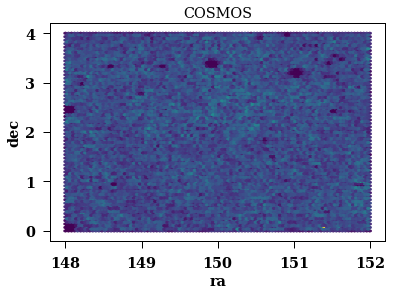

In [6]:
mask = (cosmos_deep['g_mask_brightstar_any'])&(cosmos_deep['r_mask_brightstar_any'])&(cosmos_deep['i_mask_brightstar_any'])&(cosmos_deep['z_mask_brightstar_any'])&(cosmos_deep['y_mask_brightstar_any'])
#& (cosmos_deep['g_mask_brightstar_halo'])& (cosmos_deep['g_mask_brightstar_dip'])& (cosmos_deep['g_mask_brightstar_ghost'])& (cosmos_deep['g_mask_brightstar_blooming'])
print(np.sum(~mask)/len(mask))
plt.hexbin(cosmos_deep[~mask]['ra'],cosmos_deep[~mask]['dec'])
plt.title('COSMOS')
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

cosmos_deep = cosmos_deep[mask]

(2331230,)
('object_id', 'object_id_isnull', 'ra', 'ra_isnull', 'dec', 'dec_isnull', 'g_psfflux_flux', 'g_psfflux_flux_isnull', 'r_psfflux_flux', 'r_psfflux_flux_isnull', 'i_psfflux_flux', 'i_psfflux_flux_isnull', 'z_psfflux_flux', 'z_psfflux_flux_isnull', 'y_psfflux_flux', 'y_psfflux_flux_isnull', 'g_psfflux_fluxerr', 'g_psfflux_fluxerr_isnull', 'r_psfflux_fluxerr', 'r_psfflux_fluxerr_isnull', 'i_psfflux_fluxerr', 'i_psfflux_fluxerr_isnull', 'z_psfflux_fluxerr', 'z_psfflux_fluxerr_isnull', 'y_psfflux_fluxerr', 'y_psfflux_fluxerr_isnull', 'g_cmodel_flux', 'g_cmodel_flux_isnull', 'r_cmodel_flux', 'r_cmodel_flux_isnull', 'i_cmodel_flux', 'i_cmodel_flux_isnull', 'z_cmodel_flux', 'z_cmodel_flux_isnull', 'y_cmodel_flux', 'y_cmodel_flux_isnull', 'g_cmodel_fluxerr', 'g_cmodel_fluxerr_isnull', 'r_cmodel_fluxerr', 'r_cmodel_fluxerr_isnull', 'i_cmodel_fluxerr', 'i_cmodel_fluxerr_isnull', 'z_cmodel_fluxerr', 'z_cmodel_fluxerr_isnull', 'y_cmodel_fluxerr', 'y_cmodel_fluxerr_isnull', 'g_fiber_flux',

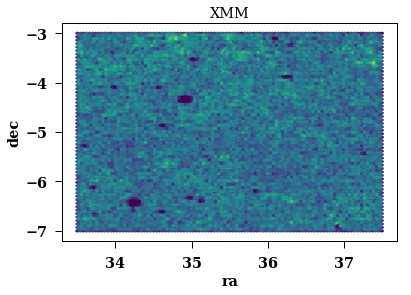

In [7]:
xmm_deep = fitsio.read(xmm_deep_fname,ext=1)
print(xmm_deep.shape)
print(xmm_deep.dtype.names)
mask = (xmm_deep['g_mask_brightstar_any'])&(xmm_deep['r_mask_brightstar_any'])&(xmm_deep['i_mask_brightstar_any'])&(xmm_deep['z_mask_brightstar_any'])&(xmm_deep['y_mask_brightstar_any'])

print(np.sum(~mask)/len(mask))
plt.hexbin(xmm_deep[~mask]['ra'],xmm_deep[~mask]['dec'])
plt.title('XMM')
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

xmm_deep = xmm_deep[mask]

# Now find the photometry to train a SOM
We have:
- 

/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


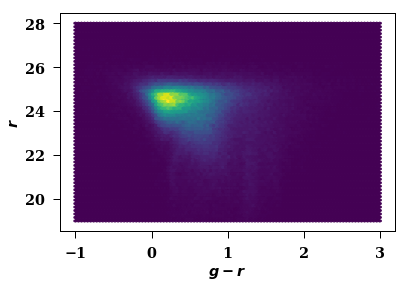

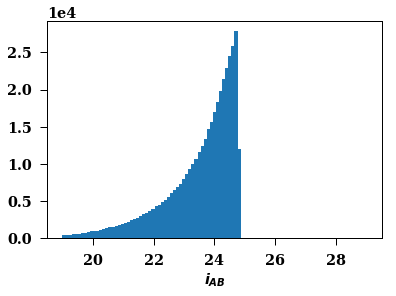

In [8]:
def abmags_nanojy(fluxes,zp=31.4):
    return zp - 2.5*np.log10(fluxes)
lims = (-1,3,19,28)
plt.hexbin(abmags_nanojy(xmm_deep['g_cmodel_flux']) - abmags_nanojy(xmm_deep['r_cmodel_flux']), abmags_nanojy(xmm_deep['r_cmodel_flux']),extent=lims)
plt.xlabel(r'$g - r$')
plt.ylabel(r'$r$')
plt.show()
plt.hist(abmags_nanojy(xmm_deep['i_cmodel_flux']),bins=np.linspace(19,29,num=100))
plt.xlabel(r'$i_{AB}$')
plt.show()

In [12]:
bands = ['g','r','i','z','y']
hsc_fluxcols = [band + '_cmodel_flux'for band in bands]
magcols = [band+'_mag' for band in bands]

hsc_fluxerrcols = [band + '_cmodel_fluxerr'for band in bands]
magerr = [band + '_magerr' for band in bands]

hsc_xmm_df = pd.DataFrame(xmm_deep.byteswap().newbyteorder(),columns=xmm_deep.dtype.names)

def get_mag_err(fluxerr,flux):
    snr = flux/fluxerr
    return (2.5/2.3)/snr

for i,band in enumerate(bands):
    print(i,band)
    hsc_xmm_df[magcols[i]] = abmags_nanojy(hsc_xmm_df[hsc_fluxcols[i]].values)
    hsc_xmm_df[magerr[i]] = get_mag_err(hsc_xmm_df[hsc_fluxerrcols[i]].values,hsc_xmm_df[hsc_fluxcols[i]].values)
    hsc_xmm_df[band + 'mag_ivar'] = 1/hsc_xmm_df[magerr[i]]**2
    
print(hsc_xmm_df.columns)

(0, 'g')
(1, 'r')
(2, 'i')
(3, 'z')
(4, 'y')
Index([u'object_id', u'object_id_isnull', u'ra', u'ra_isnull', u'dec',
       u'dec_isnull', u'g_psfflux_flux', u'g_psfflux_flux_isnull',
       u'r_psfflux_flux', u'r_psfflux_flux_isnull',
       ...
       u'rmag_ivar', u'i_mag', u'i_magerr', u'imag_ivar', u'z_mag',
       u'z_magerr', u'zmag_ivar', u'y_mag', u'y_magerr', u'ymag_ivar'],
      dtype='object', length=287)


/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in divide
  if sys.path[0] == '':


In [13]:
hsc_xmm_df

,object_id,object_id_isnull,ra,ra_isnull,dec,dec_isnull,g_psfflux_flux,g_psfflux_flux_isnull,r_psfflux_flux,r_psfflux_flux_isnull,...,rmag_ivar,i_mag,i_magerr,imag_ivar,z_mag,z_magerr,zmag_ivar,y_mag,y_magerr,ymag_ivar
0,36420386367222995,False,33.518648,False,-6.412665,False,808.848511,False,1115.296631,False,...,775.017578,22.787394,0.022414,1990.483032,22.457909,0.039320,646.793640,22.708813,0.096202,108.051613
1,36420394957161852,False,33.509134,False,-5.987075,False,167.254211,False,234.576324,False,...,22.906618,24.481548,0.051466,377.541901,24.253897,0.090543,121.981171,23.639736,0.122002,67.183571
2,36424634089881541,False,35.059176,False,-6.866507,False,1735.107056,False,6169.938965,False,...,11266.391602,21.115742,0.005430,33921.164062,20.793383,0.007343,18544.498047,20.658108,0.015218,4317.942871
3,36424638384847089,False,35.038240,False,-6.757763,False,253.415344,False,167.312424,False,...,10.310637,24.381847,0.124920,64.081711,23.277456,0.082736,146.087158,22.685715,0.161990,38.108513
4,36424646974785874,False,35.022919,False,-6.356621,False,408.300446,False,650.170715,False,...,341.880615,23.556566,0.036182,763.880920,23.691814,0.095608,109.399185,23.432091,0.166963,35.872410
5,36424646974787283,False,35.052156,False,-6.323747,False,362.007935,False,555.354126,False,...,189.593658,23.726683,0.032501,946.659973,23.373264,0.053495,349.437164,23.353699,0.129101,59.998962
6,36424646974789354,False,35.019848,False,-6.275541,False,490.997284,False,735.535889,False,...,256.337128,23.725954,0.064070,243.606003,23.613636,0.103683,93.022713,24.024105,0.313461,10.177322
7,36424646974790201,False,35.018313,False,-6.255265,False,298.002533,False,892.385559,False,...,448.070984,23.398232,0.025831,1498.686401,23.090652,0.039791,631.569946,22.880272,0.076548,170.661606
8,36424651269739250,False,35.015372,False,-6.111596,False,289.675720,False,404.931458,False,...,139.824570,24.075869,0.064574,239.820496,23.938581,0.130431,58.781219,24.183584,0.369846,7.310695
9,36424651269753478,False,35.048696,False,-6.159067,False,485.664520,False,611.112732,False,...,265.384247,23.968462,0.041990,567.170715,23.754564,0.083917,142.004120,23.706411,0.204562,23.897425


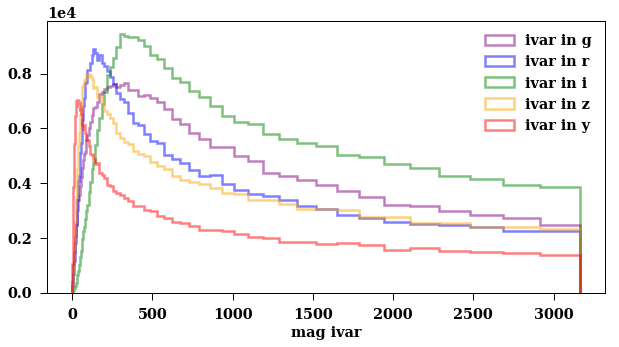

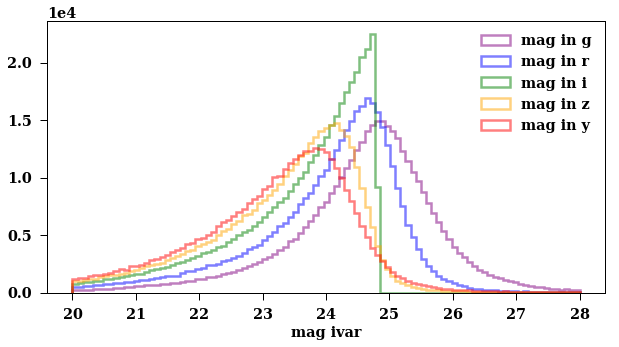

In [14]:
colors = ['purple','blue','green','orange','red']
plt.figure(figsize=(10,5))
for i,band in enumerate(bands):
    plt.hist(hsc_xmm_df[band+'mag_ivar'],alpha=0.5,histtype='step',bins=np.logspace(0,3.5,num=100),linewidth=2.5,color=colors[i],label = 'ivar in ' + band)
plt.xlabel('mag ivar')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10,5))
for i,band in enumerate(bands):
    plt.hist(hsc_xmm_df[band+'_mag'],alpha=0.5,histtype='step',bins=np.linspace(20,28,num=100),linewidth=2.5,color=colors[i],label = 'mag in ' + band)
plt.xlabel('mag ivar')
plt.legend(loc='upper right')
plt.show()

In [24]:
cols = [band +'_mag' for band in bands]
ivar_cols = [band+'mag_ivar' for band in bands]

#randomly sample the HSC data:
rand_ind = np.random.randint(0, len(hsc_xmm_df), size=1000, dtype=int).astype(int)


convert_dict = {'g_mag': float, 
                'r_mag': float, 
                'i_mag': float, 
                'z_mag': float, 
                'y_mag': float,
                'gmag_ivar': float, 
                'rmag_ivar': float, 
                'imag_ivar': float, 
                'zmag_ivar': float, 
                'ymag_ivar': float 
               } 
hsc_xmm_df.astype(convert_dict,inplace=True)
somvals = hsc_xmm_df.iloc[rand_ind][cols]
som_ivar = hsc_xmm_df.iloc[rand_ind][ivar_cols]
data = hsc_xmm_df.iloc[rand_ind][cols+ivar_cols]

color_frame = convert_catalog_to_color_array(data,cols,ivar_cols)
print(len(color_frame))
print(np.shape(color_frame[0]))

color_frame = np.hstack([color_frame[0],color_frame[1]])

#sompz is causing problems, let's just do my simple som
som = SOM(x=10, y=10, input_dim=color_frame.shape[1], random_start=True)

#whiten the data
print(color_frame.shape)
data_one,datalims = som.whiten_data(color_frame,mode='linear',verbose=True)
print(data_one)

converting g_mag - r_mag
converting r_mag - i_mag
converting i_mag - z_mag
converting z_mag - y_mag
2
(1000, 5)
(1000, 10)
(10, 1)
(10, 1)
[[9.68159589e-01 9.38613065e-01 9.79182488e-01 ... 3.61233852e-04
  1.77836579e-04 0.00000000e+00]
 [9.78723060e-01 9.46460327e-01 9.83944872e-01 ... 1.70933644e-03
  1.87503987e-03 0.00000000e+00]
 [9.69233040e-01 9.36666724e-01 9.78304674e-01 ... 2.30707512e-04
  1.50974064e-04 0.00000000e+00]
 ...
 [9.66148250e-01 9.38297790e-01 9.78906654e-01 ... 5.07713447e-04
  2.90235969e-04 0.00000000e+00]
 [9.75025777e-01 9.49626171e-01 9.83462939e-01 ... 2.41512584e-02
  3.47420684e-02 0.00000000e+00]
 [9.71095383e-01 9.37123738e-01 9.78155022e-01 ... 1.17107983e-04
  9.63095918e-05 0.00000000e+00]]


/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide


In [25]:
start = time() #train the custom som with a small test
som.train(data_one, num_iterations=500)
print('time elapsed: {}'.format(time()-start))    

time elapsed: 482.666806936


In [26]:
#look at the occupancy for a simple 10 by 10 som

#at the start:
it,weights = som.history[0]
#print(weights)
occup = som.get_occup(som,weights,data)
plt.imshow(occup.reshape(10,10))
plt.title('before training')
plt.show()

it,weights = som.history[1]
#print(weights)
occup = som.get_occup(som,weights,data)
plt.imshow(occup.reshape(10,10))
plt.title('middle training')
plt.show()

#at the end
it,weights = som.history[-1]
occup = som.get_occup(som,weights,data)

plt.imshow(occup.reshape(10,10))
plt.title('after training')
plt.show()

TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('S32') dtype('S32') dtype('S32')

In [ ]:
#som = train_som(somvals, som_ivar, map_shape=[10, 10], learning_rate=0.5, max_iter=1e3, min_val=1e-4, verbose=True, diag_ivar=False, replace=False)
"""Calculate Self Organizing Map

Parameters
----------
x :             input data of shape (n_samples, n_dim)
ivar :          inverse variance of input data (n_samples, n_dim, n_dim)
map_shape :     desired output map shape = [dim1, dim2]. (n_out_dim,)
learning_rate : float usually between 0 and 1. Sets how large of a
                change we can effect in the weights at each step by
                multiplying the change by:
                    learning_rate ** (step_t / total_t)
max_iter :      maximum number of steps in algorithm fit
min_val :       minimum parameter difference we worry about in updating
                SOM. This in practice usually doesn't come up, as we limit
                the range of cells a SOM may update to be less than one
                wrap around the map.
verbose :       Print updates?

Returns
-------
w : self organizing map weights (dim1, dim2, n_dims)

Notes
-----
Suggest whitening your data to span 0-1 range before training

"""

time elapsed: 7700.63557005


"Calculate Self Organizing Map\n\nParameters\n----------\nx :             input data of shape (n_samples, n_dim)\nivar :          inverse variance of input data (n_samples, n_dim, n_dim)\nmap_shape :     desired output map shape = [dim1, dim2]. (n_out_dim,)\nlearning_rate : float usually between 0 and 1. Sets how large of a\n                change we can effect in the weights at each step by\n                multiplying the change by:\n                    learning_rate ** (step_t / total_t)\nmax_iter :      maximum number of steps in algorithm fit\nmin_val :       minimum parameter difference we worry about in updating\n                SOM. This in practice usually doesn't come up, as we limit\n                the range of cells a SOM may update to be less than one\n                wrap around the map.\nverbose :       Print updates?\n\nReturns\n-------\nw : self organizing map weights (dim1, dim2, n_dims)\n\nNotes\n-----\nSuggest whitening your data to span 0-1 range before training\n

In [ ]:
som